In [1]:
import os
import sys
parent_dir = os.path.join(os.getcwd(), '..')
if parent_dir not in sys.path: sys.path.append(parent_dir)
from utility.data_utils import *
from utility.visuals import *
from model.dimensional_reduction import *
from model.gans import *
from model.rf import *
from model.dnn import *
from model.knn import *
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
load_dotenv()
DATA_DIR = os.getenv("DATA_DIR")
PCA_N_COMPONENTS = float(os.getenv("PCA_N_COMPONENTS"))
NOISE_DIM = int(os.getenv("NOISE_DIM"))
BATCH_SIZE = int(os.getenv("BATCH_SIZE"))
NUM_EPOCHS = int(os.getenv("NUM_EPOCHS"))
NUM_EPOCHS = 7000


files = get_files(DATA_DIR)
file = files[0]
city_name = file.split('\\')[-1].split('.csv')[0].split('_')[0]

path_name = process_and_transform_data(file, resolution=.5, overwrite=True)
with open(path_name, 'rb') as f:
    result_dict = pickle.load(f)
labels = result_dict['labels']
encoder = result_dict['encoder']
MAX_LEN = result_dict['max length']
file_name = result_dict['file name']
WIDTH = result_dict['width']
HEIGHT = result_dict['height']
unique_labels = [u for u in labels if np.array(np.where(u != 0)).T.shape[0] > 1]
train_labels, test_labels = train_test_split(np.expand_dims(np.array(unique_labels), axis=1), test_size=.2)
pca = PCATransformer(n_components=PCA_N_COMPONENTS)
transformed = pca.fit_and_predict(
    train_labels.reshape(train_labels.shape[0], -1)
)
knn = KNNFeaturesExtractor()
knn.fit(transformed)
features = knn.predict(transformed)
features = features.reshape(len(features), -1)

OUTPUT_DIM = transformed.shape[1]
CONDITION_DIM = features.shape[-1]
x, y, _, _ = get_x_y(test_labels, MAX_LEN=MAX_LEN, encoder=encoder)
x = np.array(x)
y = np.array(y)
test_pca = PCATransformer(n_components=transformed.shape[-1])
test_transformed = test_pca.fit_and_predict(
    x.reshape(x.shape[0], -1)
)
test_features = knn.predict(test_transformed)
test_features = test_features.reshape(len(test_features), -1)

dnn_manager = DNNManager(
    input_dim=CONDITION_DIM, 
    output_dim=OUTPUT_DIM, 
    batch_size=BATCH_SIZE, 
    num_epochs=NUM_EPOCHS,
    lr=3e-4,
    betas=(.5, 0.999)
)
dnn_manager.train(features, transformed, verbose=1)

gan_manager = GANManager(
    noise_dim=NOISE_DIM,
    condition_dim=features.shape[-1],
    output_dim=transformed.shape[1],
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    lr=0.0002,
    betas = (.5, 0.999),
)
gan_manager.train(features, transformed, verbose=1)

rf_manager = RandomForestManager()
rf_manager.train(features, transformed)

knn_manager = KNNManager(n_neighbors=1)
knn_manager.train(features, transformed)

gan_output = gan_manager.predict(test_features)
gan_output_shaped = test_pca.predict(gan_output, inverse=True)\
    .reshape(len(gan_output), x.shape[-2], x.shape[-1])
gan_output_shaped[gan_output_shaped < 0] = 0

dnn_output = dnn_manager.predict(test_features)
dnn_output_shaped = test_pca.predict(dnn_output, inverse=True)\
    .reshape(len(dnn_output), x.shape[-2], x.shape[-1])
dnn_output_shaped[dnn_output_shaped < 0] = 0

rf_output = rf_manager.predict(test_features)
rf_output_shaped = test_pca.predict(rf_output, inverse=True)\
    .reshape(len(rf_output), x.shape[-2], x.shape[-1])
rf_output_shaped[rf_output_shaped < 0] = 0

knn_output = knn_manager.predict(test_features)
knn_output_shaped = test_pca.predict(knn_output, inverse=True)\
    .reshape(len(knn_output), x.shape[-2], x.shape[-1])
knn_output_shaped[knn_output_shaped < 0] = 0



original dataset size: 238
dataset size with duplicates removed: 172


100%|██████████| 7000/7000 [12:59<00:00,  8.98it/s]


Train MSE: 0.8965


In [9]:

SIGMA = 3
# Apply Gaussian filter to each 2D image in a set of images
def apply_gaussian(images, sigma):
    # images: numpy array with shape (n_samples, height, width)
    return np.array([gaussian_filter(img, sigma=sigma) for img in images])

# Apply filter to each model's output
gan_filtered = apply_gaussian(gan_output_shaped, sigma=SIGMA)
dnn_filtered = apply_gaussian(dnn_output_shaped, sigma=SIGMA)
rf_filtered  = apply_gaussian(rf_output_shaped, sigma=SIGMA)
knn_filtered = apply_gaussian(knn_output_shaped, sigma=SIGMA)
act = x + y
act = act[:, 0, :]
# Ensure the ground truth 'act' is filtered per image (if not already)
act_filtered = np.array([gaussian_filter(img, sigma=SIGMA) for img in act])

import numpy as np
import pandas as pd

# Function to compute the symmetric overlap (intersection over union) between two images
def compute_overlap(img1, img2):
    # Both images are assumed to have values between 0 and 1
    numerator = np.sum(np.minimum(img1, img2))
    denominator = np.sum(np.maximum(img1, img2))
    return numerator / denominator if denominator != 0 else 0

# Function to compute the Bhattacharyya coefficient between two images
def compute_bhattacharyya(img1, img2):
    # Optionally, normalize images so that their sums equal 1
    p = img1 / np.sum(img1) if np.sum(img1) != 0 else img1
    q = img2 / np.sum(img2) if np.sum(img2) != 0 else img2
    return np.sum(np.sqrt(p * q))

from scipy.spatial.distance import jensenshannon

# Function to compute the Jensen-Shannon Divergence (JSD) between two images
def compute_jsd(img1, img2):
    # Normalize images so that they sum to 1 (convert to probability distributions)
    p = img1 / np.sum(img1) if np.sum(img1) != 0 else img1
    q = img2 / np.sum(img2) if np.sum(img2) != 0 else img2
    # Compute Jensen-Shannon Divergence (JSD)
    return jensenshannon(p.flatten(), q.flatten()) ** 2  # Square to get original JSD

# Function to compute RMSE between two images
def compute_rmse(img1, img2):
    return np.sqrt(mean_squared_error(img1, img2))

# Calculate average metrics for each model
jsd_gan = np.mean([compute_jsd(act_filtered[i], gan_filtered[i]) for i in range(len(act_filtered))])
jsd_dnn = np.mean([compute_jsd(act_filtered[i], dnn_filtered[i]) for i in range(len(act_filtered))])
jsd_rf  = np.mean([compute_jsd(act_filtered[i], rf_filtered[i]) for i in range(len(act_filtered))])
jsd_knn = np.mean([compute_jsd(act_filtered[i], knn_filtered[i]) for i in range(len(act_filtered))])

overlap_gan = np.mean([compute_overlap(act_filtered[i], gan_filtered[i]) for i in range(len(act_filtered))])
overlap_dnn = np.mean([compute_overlap(act_filtered[i], dnn_filtered[i]) for i in range(len(act_filtered))])
overlap_rf  = np.mean([compute_overlap(act_filtered[i], rf_filtered[i])  for i in range(len(act_filtered))])
overlap_knn = np.mean([compute_overlap(act_filtered[i], knn_filtered[i]) for i in range(len(act_filtered))])

bhatt_gan = np.mean([compute_bhattacharyya(act_filtered[i], gan_filtered[i]) for i in range(len(act_filtered))])
bhatt_dnn = np.mean([compute_bhattacharyya(act_filtered[i], dnn_filtered[i]) for i in range(len(act_filtered))])
bhatt_rf  = np.mean([compute_bhattacharyya(act_filtered[i], rf_filtered[i])  for i in range(len(act_filtered))])
bhatt_knn = np.mean([compute_bhattacharyya(act_filtered[i], knn_filtered[i]) for i in range(len(act_filtered))])

rmse_gan = np.mean([compute_rmse(act_filtered[i], gan_filtered[i]) for i in range(len(act_filtered))])
rmse_dnn = np.mean([compute_rmse(act_filtered[i], dnn_filtered[i]) for i in range(len(act_filtered))])
rmse_rf  = np.mean([compute_rmse(act_filtered[i], rf_filtered[i]) for i in range(len(act_filtered))])
rmse_knn = np.mean([compute_rmse(act_filtered[i], knn_filtered[i]) for i in range(len(act_filtered))])

# Create a DataFrame to store the evaluation metrics
results_df = pd.DataFrame({
    "Model": ["GAN", "DNN", "RF", "KNN"],
    "Overlap (IoU)": [overlap_gan, overlap_dnn, overlap_rf, overlap_knn],
    "Jensen-Shannon Divergence": [jsd_gan, jsd_dnn, jsd_rf, jsd_knn],
    "RMSE": [rmse_gan, rmse_dnn, rmse_rf, rmse_knn],
    "Filtered Output": [gan_filtered, dnn_filtered, rf_filtered, knn_filtered]
})

print(results_df)


  Model  Overlap (IoU)  Jensen-Shannon Divergence      RMSE  \
0   GAN       0.314986                   0.239308  0.004589   
1   DNN       0.417264                   0.181246  0.003232   
2    RF       0.382312                   0.199270  0.002797   
3   KNN       0.368897                   0.214816  0.003103   

                                     Filtered Output  
0  [[[0.008994440452713574, 0.00990211927227938, ...  
1  [[[0.019665438046629406, 0.018890725422233832,...  
2  [[[0.002998595154420497, 0.0034048136054111236...  
3  [[[0.009725605714762295, 0.009828968888486367,...  


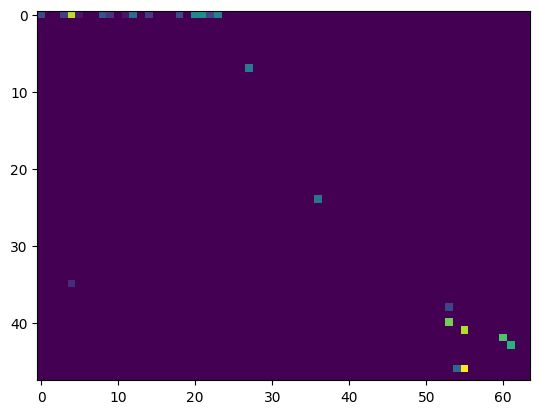

In [19]:
plt.imshow(knn_output_shaped[5])

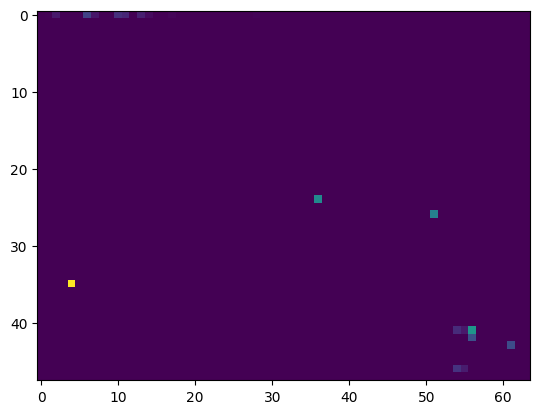

In [11]:
plt.imshow(gan_output_shaped[0])

In [12]:
i = 0
act_filtered[i], gan_filtered[i]

np.sum(np.minimum(act_filtered[i], gan_filtered[i]))

2.231814170921875

In [13]:
output = results_df[['Model', 'Filtered Output']]

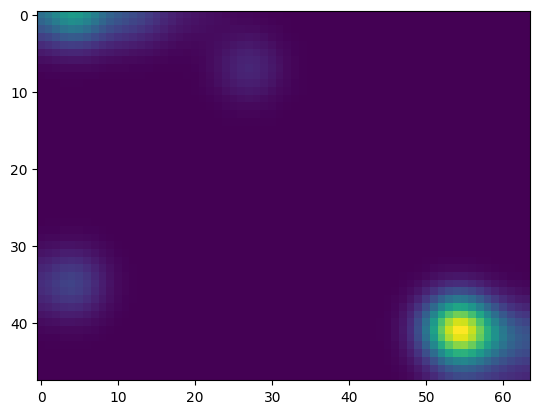

In [14]:

val = output[output.Model == 'GAN']['Filtered Output'].values[0]
plt.imshow(val[7])

In [15]:
results_df.drop(["Filtered Output"], axis=1)

,Model,Overlap (IoU),Jensen-Shannon Divergence,RMSE
0,GAN,0.314986,0.239308,0.004589
1,DNN,0.417264,0.181246,0.003232
2,RF,0.382312,0.199270,0.002797
3,KNN,0.368897,0.214816,0.003103
